# Node generation

Since id_ultimo_jefe has many categories that cannot be reduced, let's create node embeddings to catch their interactions

## Preparing environment

In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec as n2v
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [2]:
train_df = pd.read_csv(paths.data_interim_dir('train_clean.csv'))
test_df = pd.read_csv(paths.data_interim_dir('test_clean.csv'))

In [3]:
target = train_df['abandono_6meses']
combined_df = pd.concat([train_df.drop('abandono_6meses', axis=1), test_df])

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4172 entries, 0 to 2019
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_colaborador        4172 non-null   int64  
 1   id_ultimo_jefe        4172 non-null   object 
 2   seniority             4172 non-null   int64  
 3   modalidad_trabajo     4172 non-null   object 
 4   distancia_oficina     4172 non-null   float64
 5   dias_baja_salud       4172 non-null   int64  
 6   genero                4172 non-null   object 
 7   canal_reclutamiento   4172 non-null   object 
 8   permanencia_promedio  4172 non-null   int64  
 9   salario               4172 non-null   int64  
 10  performance_score     4172 non-null   float64
 11  psi_score             4172 non-null   int64  
 12  estado_civil          4172 non-null   object 
 13  age                   4172 non-null   int64  
 14  join_year             4172 non-null   int64  
 15  join_month            4172

## Creating edges

In [5]:
edges = combined_df[['id_colaborador', 'id_ultimo_jefe']].values.tolist()

## Creating graph

In [6]:
G = nx.Graph()
G.add_edges_from(edges)

## Plotting graph

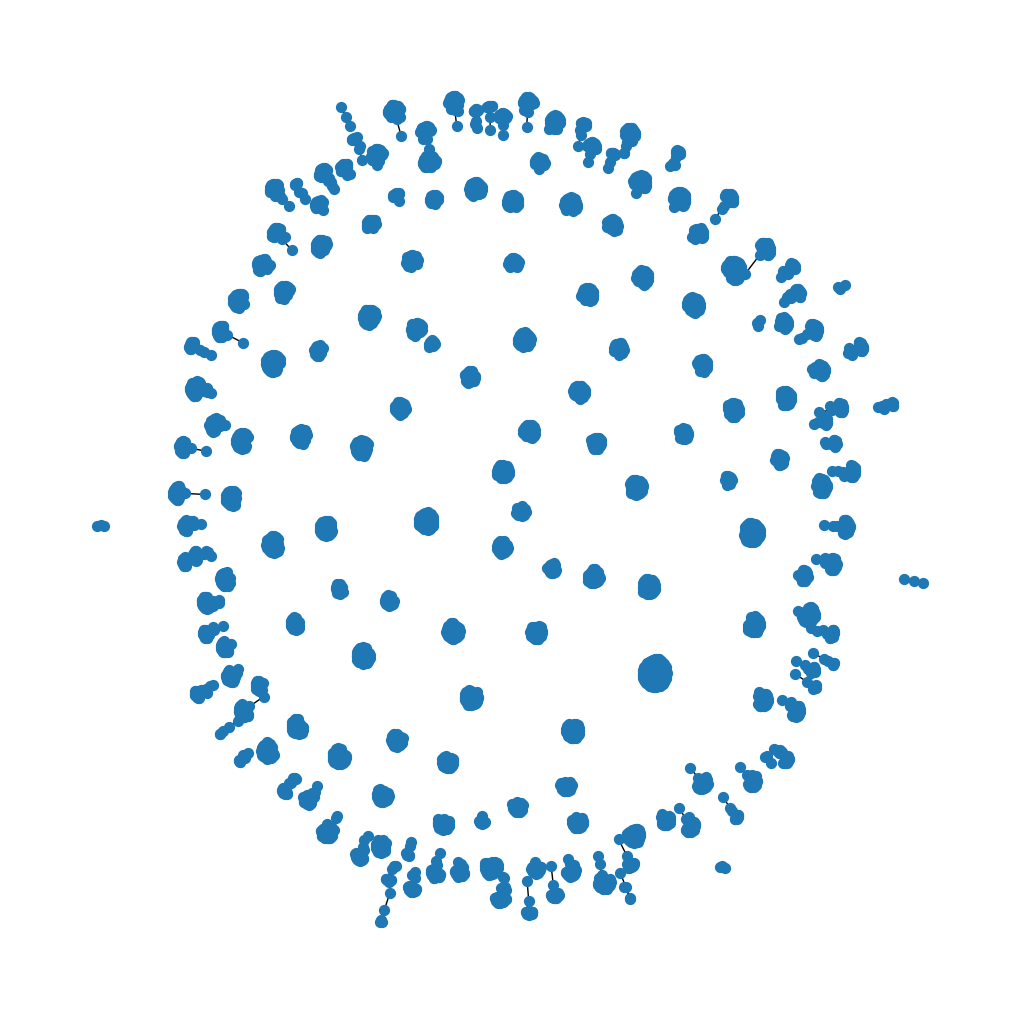

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G, node_size=50, font_size=8)
plt.show()

## Generating Node Embeddings

In [8]:
# Precompute probabilities and generate walks

node2vec = n2v(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 4346/4346 [00:00<00:00, 11172.14it/s]


## Storing Node Embeddings

In [9]:
# Create a dataframe to store the embeddings
node_embeddings = pd.DataFrame([model.wv[str(node)] for node in G.nodes()], index=G.nodes())

In [10]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
100247,-0.277591,-0.895840,0.921852,-0.001512,0.204660,0.599929,0.185935,0.420538,-0.349808,0.616361,...,-0.003029,-0.628251,0.328559,-0.358955,0.642199,-0.743817,0.458475,-0.881020,0.220879,0.534090
102074.0,-0.694206,-1.393690,1.807583,-0.116703,0.806173,0.085830,0.053083,0.681656,-0.525790,0.823700,...,-0.198862,-0.801981,0.515141,-0.607008,1.190764,-1.789731,1.467514,-1.883330,0.460742,1.282448
103355,-0.544113,-0.712621,1.575613,0.361295,0.118179,0.434358,-0.140625,0.384316,0.465705,0.932039,...,0.453234,-0.224880,0.794368,0.342318,0.945210,0.071948,-0.258466,-1.009321,-0.236078,0.727538
102115.0,-0.609403,-0.810514,2.600578,0.601291,0.376799,0.483721,-0.131740,0.374591,0.852397,1.430245,...,0.734414,-0.487997,1.301363,0.495097,1.136901,0.041778,-0.254074,-1.453778,-0.344678,1.661942
100669,-0.166122,-0.768085,0.617884,0.313788,-0.220732,1.141344,0.102524,0.582969,-0.747863,0.480682,...,0.005970,-0.405479,-0.044880,-0.427146,0.891150,-0.276429,0.154514,-0.544149,0.140059,0.520333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103755,-0.437153,-0.902201,0.839328,-0.202943,0.031924,1.388146,0.454288,0.629238,-1.112915,0.672190,...,0.496801,-0.427122,0.289774,-0.639561,0.833371,-0.840290,0.322839,-1.038255,0.457190,0.293931
103976,-0.611145,-0.918505,0.131571,0.595952,-0.821419,0.465674,0.358121,-0.017337,0.828451,1.191223,...,0.004554,-0.315517,-0.308633,0.342051,0.797213,-1.189959,-0.172389,-0.835790,0.088017,0.529293
104115,-0.628648,-0.985337,0.432600,0.190684,-0.190575,0.592600,-0.133957,0.591998,-0.504324,0.750012,...,0.032615,-0.831680,0.737891,-0.406286,0.622890,-0.731715,0.471277,-0.637464,0.749904,0.037661
103920,-0.379850,-0.852393,0.700189,0.619708,-0.439888,1.461387,-0.042001,0.422166,-0.645586,1.320680,...,0.444521,-0.760224,0.775005,-0.040905,0.708686,-0.074359,-0.638407,-1.016364,0.806152,0.623078


## Merge node embeddings with original data

In [11]:
id_colaborador_embeddings = node_embeddings.loc[combined_df['id_colaborador']].reset_index(drop=True)
id_ultimo_jefe_embeddings = node_embeddings.loc[combined_df['id_ultimo_jefe'].astype(str)].reset_index(drop=True)

In [12]:
# Rename columns to distinguish between the embeddings
id_colaborador_embeddings.columns = [f'id_colaborador_emb_{i}' for i in range(id_colaborador_embeddings.shape[1])]
id_ultimo_jefe_embeddings.columns = [f'id_ultimo_jefe_emb_{i}' for i in range(id_ultimo_jefe_embeddings.shape[1])]

In [13]:
# Merge embeddings with the combined dataframe
combined_df = pd.concat([combined_df.reset_index(drop=True), id_colaborador_embeddings, id_ultimo_jefe_embeddings], axis=1)

## Split back into Train and Test DataFrames

In [14]:
train_new = combined_df.loc[:len(train_df)-1,:].reset_index(drop=True)
test_new = combined_df.loc[len(train_df):, :].reset_index(drop=True)

In [15]:
train_new = pd.concat([train_new, target], axis=1)

In [16]:
train_new

,id_colaborador,id_ultimo_jefe,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,salario,...,id_ultimo_jefe_emb_55,id_ultimo_jefe_emb_56,id_ultimo_jefe_emb_57,id_ultimo_jefe_emb_58,id_ultimo_jefe_emb_59,id_ultimo_jefe_emb_60,id_ultimo_jefe_emb_61,id_ultimo_jefe_emb_62,id_ultimo_jefe_emb_63,abandono_6meses
0,100247,102074.0,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,140011,...,-0.801981,0.515141,-0.607008,1.190764,-1.789731,1.467514,-1.883330,0.460742,1.282448,0
1,103355,102115.0,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,182774,...,-0.487997,1.301363,0.495097,1.136901,0.041778,-0.254074,-1.453778,-0.344678,1.661942,1
2,100669,102060.0,1,Híbrida,4.950,3,Mujer,Referidos,11,682106,...,0.172745,-0.682354,-1.405759,1.652914,-0.310386,0.343639,-0.371781,-0.110042,1.463334,0
3,103760,102062.0,1,Híbrida,13.030,2,Hombre,Linkedin,2,270232,...,-1.304928,-1.117234,-0.387424,-2.121872,0.758913,-1.692304,-2.980264,0.823163,0.404916,1
4,100965,102062.0,1,Híbrida,13.045,2,Hombre,Linkedin,2,266804,...,-1.304928,-1.117234,-0.387424,-2.121872,0.758913,-1.692304,-2.980264,0.823163,0.404916,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,103567,102171.0,1,Presencial,1.965,8,Mujer,Portal Web,3,281159,...,-0.327656,-0.562141,0.703732,1.247030,-1.820396,-0.321687,-1.825227,-0.037081,0.713443,1
2148,104098,102172.0,1,Presencial,0.805,12,Mujer,Linkedin,13,460337,...,-1.855235,-0.586002,1.605304,0.421283,-0.385762,0.570238,-1.671858,-0.569512,-0.315342,1
2149,103987,102155.0,1,Presencial,1.625,1,Hombre,Portal Web,11,633879,...,0.464271,2.026845,-0.734687,1.375340,1.614135,-1.759578,-0.524065,-1.017274,2.524502,1
2150,103810,102141.0,1,Presencial,5.665,2,Hombre,Portal Web,6,793977,...,-1.010747,-0.929971,0.818219,0.183968,0.325452,-0.361736,-1.372307,-0.342025,-0.210882,1


In [17]:
test_new

,id_colaborador,id_ultimo_jefe,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,salario,...,id_ultimo_jefe_emb_54,id_ultimo_jefe_emb_55,id_ultimo_jefe_emb_56,id_ultimo_jefe_emb_57,id_ultimo_jefe_emb_58,id_ultimo_jefe_emb_59,id_ultimo_jefe_emb_60,id_ultimo_jefe_emb_61,id_ultimo_jefe_emb_62,id_ultimo_jefe_emb_63
0,100486,102115.0,1,Híbrida,0.795,2,Hombre,Ferias & Networking,2,181654,...,0.734414,-0.487997,1.301363,0.495097,1.136901,0.041778,-0.254074,-1.453778,-0.344678,1.661942
1,103752,102074.0,1,Híbrida,1.715,1,Mujer,Ferias & Networking,1,140986,...,-0.198862,-0.801981,0.515141,-0.607008,1.190764,-1.789731,1.467514,-1.883330,0.460742,1.282448
2,103937,102150.0,1,Híbrida,2.375,1,Hombre,Portal Web,6,406690,...,0.358321,-2.234184,-1.692420,0.035372,0.643546,-0.370918,-0.622237,-2.598448,1.874470,-0.370779
3,101744,102172.0,1,Híbrida,2.185,3,Hombre,Linkedin,3,249107,...,0.495716,-1.855235,-0.586002,1.605304,0.421283,-0.385762,0.570238,-1.671858,-0.569512,-0.315342
4,101037,102060.0,1,Híbrida,4.660,3,Hombre,Referidos,10,698318,...,-0.376102,0.172745,-0.682354,-1.405759,1.652914,-0.310386,0.343639,-0.371781,-0.110042,1.463334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,103755,102161.0,1,Presencial,2.995,2,Mujer,Portal Web,16,700814,...,1.435179,1.273617,-0.284020,-2.535157,-0.360593,-2.551272,1.754389,-2.153122,1.707685,0.293607
2016,103976,102171.0,1,Presencial,2.775,0,Mujer,Portal Web,5,677071,...,0.384194,-0.327656,-0.562141,0.703732,1.247030,-1.820396,-0.321687,-1.825227,-0.037081,0.713443
2017,104115,102144.0,1,Presencial,3.990,1,Hombre,Portal Web,7,876285,...,-0.038262,-1.389933,1.771561,-0.497202,0.559100,-1.274778,1.416516,-0.750763,1.706643,0.099388
2018,103920,102152.0,1,Presencial,7.100,1,Mujer,Linkedin,8,719102,...,2.335604,-1.474505,3.001765,1.667583,-0.892334,2.103749,-3.035308,-1.996918,2.964310,2.106229


## Saving new DataFrames

In [18]:
train_new.to_csv(paths.data_interim_dir('train_node.csv'), index=False, sep=',')
test_new.to_csv(paths.data_interim_dir('test_node.csv'), index=False, sep=',')